In [1]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

import covid
import covid.util as util

# Load Data and Set Parameters

In [47]:
data = util.load_world_data()
place = 'Italy'

util.run_place(data, 
               place, 
               start='2020-03-04', 
               end='2020-04-15',
               T_future=4*7,
               num_warmup=100, 
               num_samples=100)

 * running MCMC


sample: 100%|██████████| 200/200 [01:05<00:00,  3.06it/s, 1023 steps of size 8.82e-03. acc. prob=0.96]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          D0     96.49      3.06     97.49     91.74    100.00     84.04      0.99
          E0   9667.02   7884.91   7777.25     36.83  22136.77    111.40      0.99
          H0    187.53    101.70    176.59     34.33    321.57    105.20      0.99
          I0   8761.84   2145.20   8471.37   5312.03  11770.40     49.10      1.00
     beta[0]      1.61      0.64      1.49      0.61      2.56     25.56      1.00
     beta[1]      1.58      0.66      1.40      0.77      2.66     37.70      0.99
     beta[2]      1.58      0.62      1.39      0.73      2.66     62.53      0.99
     beta[3]      1.62      0.71      1.45      0.85      2.87     80.64      0.99
     beta[4]      1.67      0.73      1.48      0.80      2.55     93.24      0.99
     beta[5]      1.67      0.66      1.55      0.80      2.51    111.19      0.99
     beta[6]      1.60      0.57      1.48      0.82      2.46     93.53      0.99
   

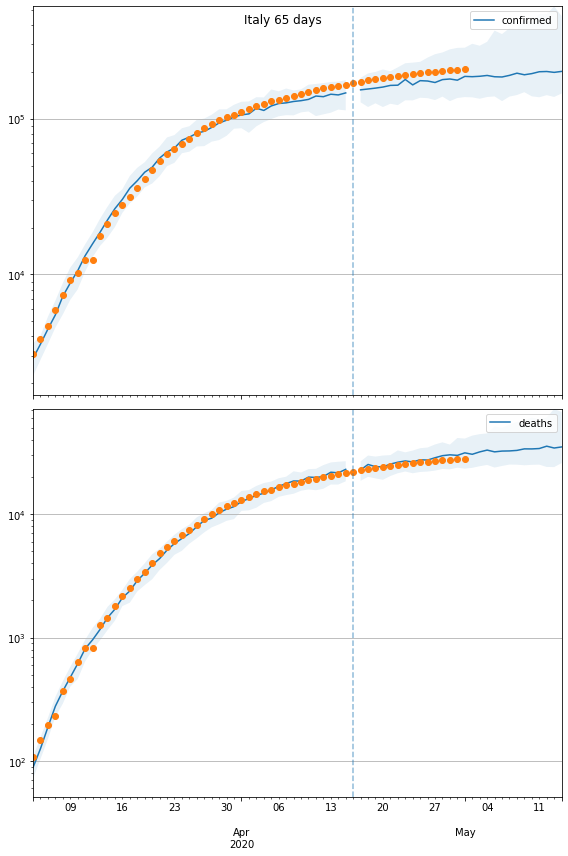

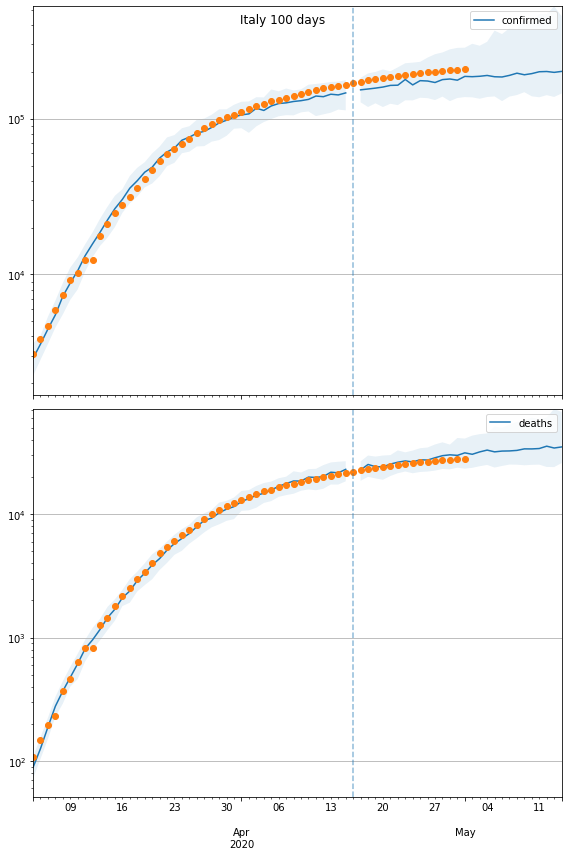

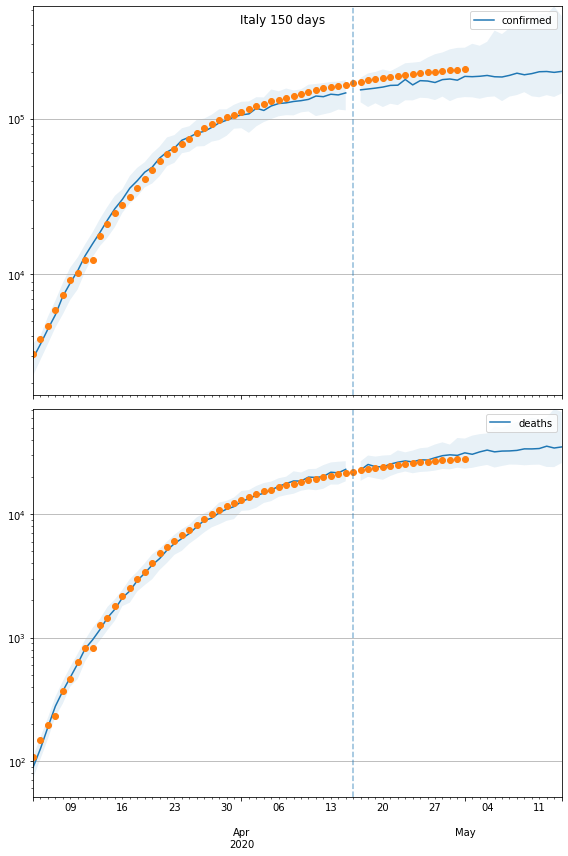

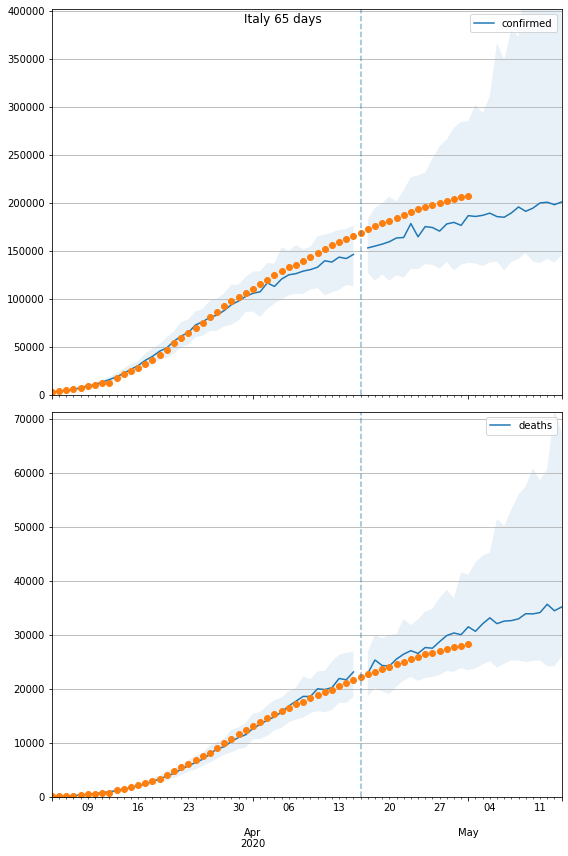

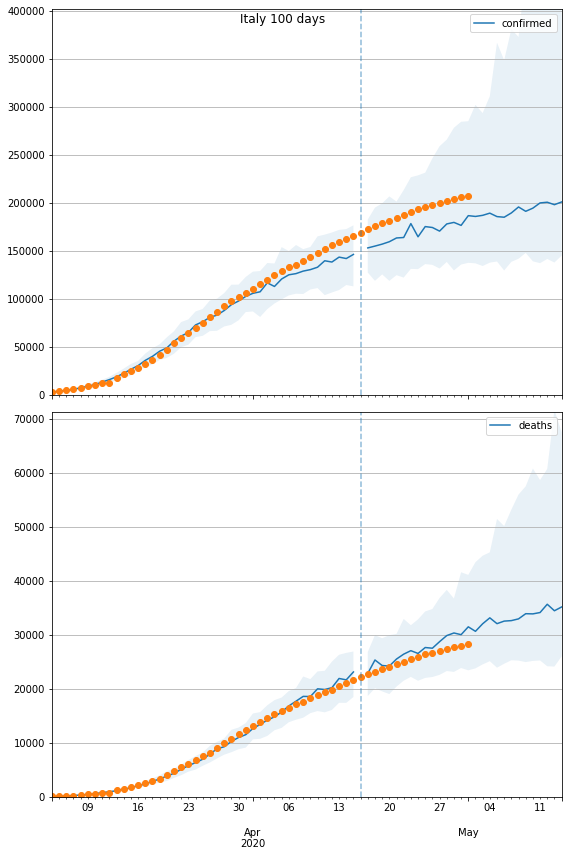

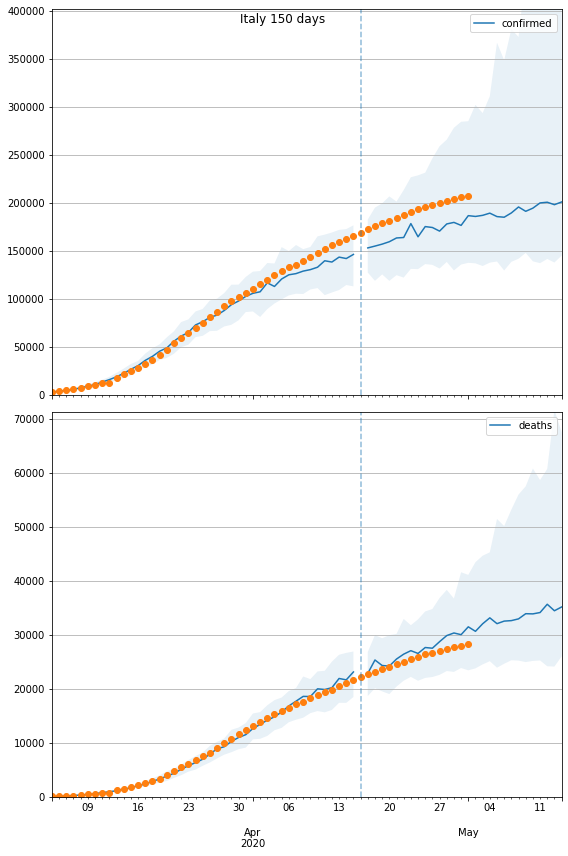

<Figure size 360x216 with 0 Axes>

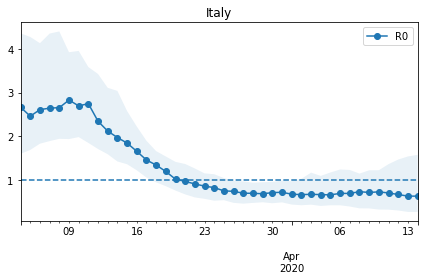

In [46]:
util.gen_forecasts(model, data, place)

(<Figure size 576x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2c79a950>)

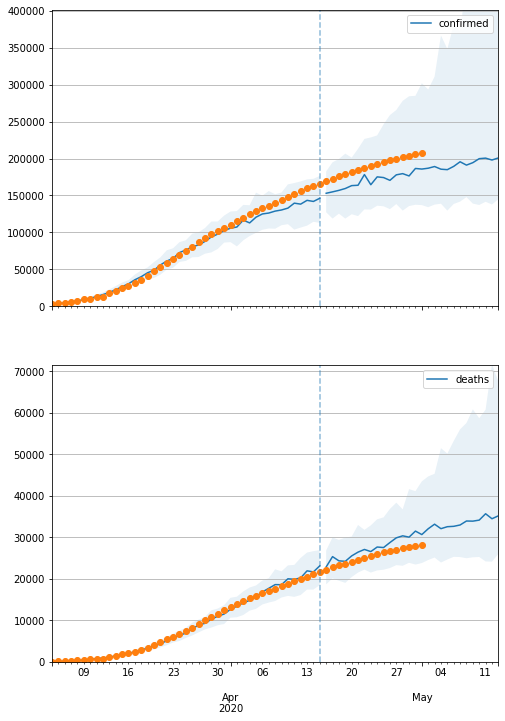

In [7]:
place = 'Italy'
start = '2020-03-04'
end = '2020-04-15'
T_future = 4*7
legend=True
ax = None
plot_fields = ['y', 'z']

prior_samples, mcmc_samples, post_pred_samples, forecast_samples = \
    util.load_samples(place)

place_data = data[place]['data'][start:]
confirmed = place_data.confirmed
death = place_data.death

util.plot_forecast(model,
                   post_pred_samples, 
                   forecast_samples,
                   T_future,
                   confirmed,
                   start='2020-03-04',
                   scale='lin',
                   death = death,
                   daily = False)

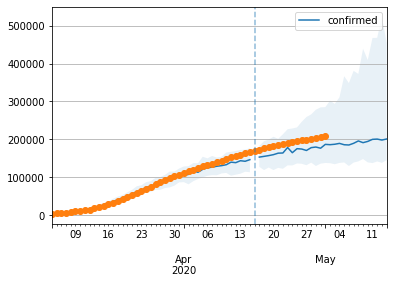

In [43]:
data = util.load_world_data()
model = covid.models.SEIRD.SEIRD()

model.plot_forecast('y', 
                    post_pred_samples, 
                    forecast_samples,
                    start,
                    T_future=7*4,
                    obs=confirmed)

plt.show()

In [37]:
%debug

> /Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/jax/numpy/lax_numpy.py(272)_check_arraylike()
    270                     if not _arraylike(arg))
    271     msg = "{} requires ndarray or scalar arguments, got {} at position {}."
--> 272     raise TypeError(msg.format(fun_name, type(arg), pos))
    273 
    274 

ipdb> up
> /Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/jax/numpy/lax_numpy.py(277)_promote_args()
    275 def _promote_args(fun_name, *args):
    276   """Convenience function to apply Numpy argument shape and dtype promotion."""
--> 277   _check_arraylike(fun_name, *args)
    278   return _promote_shapes(fun_name, *_promote_dtypes(*args))
    279 

ipdb> up
> /Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/jax/numpy/lax_numpy.py(422)<lambda>()
    420     fn = lambda x1, x2: lax_fn(*_promote_args_inexact(numpy_fn, x1, x2))
    421   else:
--> 422     fn = lambda x1, x2: lax_fn(*_promote_args(numpy_fn.__name__, x1, x2))
    423   return _wraps(

In [ ]:
place = 'Italy'
start = '2020-03-04'
end = '2020-04-15'
T_future = 4*7
legend=True
ax = None
plot_fields = ['y', 'z']

prior_samples, mcmc_samples, post_pred_samples, forecast_samples = \
    util.load_samples(place)

confirmed = data[place]['data'].confirmed[start:]
death = data[place]['data'].deaths[start:]

fig, ax = plt.subplots(figsize=(8,5))

# Plot posterior predictive
t = pd.date_range(start=start, end=end, freq="D")
model.plot_samples(post_pred_samples, ax=ax, t=t, plot_fields=plot_fields)

# Plot forecast predictive
forecast_start = pd.to_datetime(end) + pd.Timedelta("1d")
t = pd.date_range(start=forecast_start, periods=T_future, freq="1d")
med, _ = model.plot_samples(forecast_samples, 
                            ax=ax, 
                            t=t, 
                            legend=False, 
                            plot_fields=plot_fields,
                            forecast=True)

# Plot observed
confirmed.plot(style='.')
death.plot(style='.')
ax.axvline(end, linestyle='--', alpha=0.5)
#ax.set_yscale('log')
ax.set_ylim(top=2*med.max())
plt.title(place)
plt.show()


# Compute error
# cum/incident confirmed/death
#

In [ ]:
## Validation: can only do cumulative for now...

# cumulative deaths 
start = forecast_start
end = death.index.max()

obs = death[start:end]

T = len(obs)
z = model.get(forecast_samples, 'z', forecast=True)[:,:T]
df = pd.DataFrame(index=obs.index, data=z.T)

point_forecast = df.median(axis=1)
err = (obs-point_forecast).rename('err')
err.plot(style='o')

mae = err.abs().mean()

plt.title(f"{place} MAE={mae:.2f}")
plt.show()

#display(df[0]-actual)
# T_obs = len(actual)
# pred = np.median(forecast_samples['z_future'][:,:T_obs], axis=0)

# err_c = np.abs(pred-actual)
# plt.plot(pred, actual, 'o')
# plt.show()

In [ ]:

prob_model.set_data()
prob_model()  # __call__
prob_model.deaths(samples, forecast=True, daily=True)
prob_model.cases(samples, forecast=True, daily=True)

prob_model.get(samples, 'S')




deaths = prob_model.cumulative_deaths(samples)

In [ ]:

class foo():
    
    def __init__(self, a):
        self.a = a
        
        
    def __call__(self):
        print(self.a)
        
f = foo(1)
f()


In [ ]:
d1 = {'a': 1, 'b': 2}
d2 = {'a': 100, 'c': 3}
d3 = {'d': 4}

d = dict(d2, **d1, **d3)

print(d)

In [41]:
x = min(10, 20, -100)
print(x)

-100
